# 1. Setup and Load Data

## 1.1. Imports and config GPU usage

In [20]:
import os
import cv2
import imghdr
import itertools

import numpy as np 
import tensorflow as tf
import pandas as pd

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.python.client import device_lib
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.models import load_model

from matplotlib import pyplot as plt

In [2]:
# print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

# print('\n', device_lib.list_local_devices())

# # Avoid OOM errors by setting GPU Memory Consumption Growth
# gpus = tf.config.experimental.list_physical_devices('GPU')
# for gpu in gpus:
#     tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
# # create a simple model
# with tf.device('GPU:0'):
#   x = tf.constant([1, 2, 3, 4, 5, 6], shape=(2, 3))
#   y = tf.constant([7, 8, 9, 10, 11, 12], shape=(3, 2))
#   z = tf.matmul(x, y)

# # check the device placement of operations
# print(z.device)

## 1.2. Remove dodgy images

In [4]:
# # Setting the path to the directory containing datasets
# data_dir = '../datasets/train_test'

# # List of acceptable image extensions
# image_extensions = ['jpeg','jpg','bmp','png']

# # Looping through each dataset in the data directory
# for dataset in os.listdir(data_dir):
#     # Looping through each image in the current dataset
#     for image in os.listdir(os.path.join(data_dir, dataset)):
#         # Creating the path to the current image
#         image_path = os.path.join(data_dir, dataset, image)
        
#         try:
#             # Reading the image using OpenCV
#             img = cv2.imread(image_path)
#             # Checking the type of the image
#             tip = imghdr.what(image_path)

#             # If the image type is not in the list of acceptable image extensions
#             if tip not in image_extensions:
#                 # Printing a message indicating that the image is not in the list of extensions
#                 print('Image not in extensions list {}'.format(image_path))
#                 # Removing the image
#                 os.remove(image_path)
                
#         except Exception as e:
#             # Printing a message indicating there was an issue with the current image
#             print('Issue with image {}'.format(image_path))

## 1.3 Load data

In [5]:
train_data_dir = '../datasets/train_test/train_images/'
label_csv = '../datasets/train.csv'

# Read train.csv file
images_labels = pd.read_csv(label_csv)

In [6]:
# Encode competition-provided labels 
label_to_id = {
    'healthy': 0,
    'scab': 1,
    'frog_eye_leaf_spot': 2,
    'rust': 3,
    'complex': 4,
    'powdery_mildew': 5,
    'scab frog_eye_leaf_spot complex': 6,
    'scab frog_eye_leaf_spot': 7,
    'frog_eye_leaf_spot complex': 8,
    'rust frog_eye_leaf_spot': 9,
    'powdery_mildew complex': 10,
    'rust complex': 11
}

id_to_label = {value:key for key, value in label_to_id.items()} 

images_labels['labels'] = images_labels['labels'].map(label_to_id)

In [7]:
# Helper functions
def make_path(row):
    return  os.path.join(train_data_dir, row.image)

# Get absolute path for images
images_labels['image'] = images_labels.apply(lambda row: make_path(row), axis=1)

# Look at the dataframe
images_labels.head()

,image,labels
0,../datasets/train_test/train_images/800113bb65...,0
1,../datasets/train_test/train_images/8002cb321f...,6
2,../datasets/train_test/train_images/80070f7fb5...,1
3,../datasets/train_test/train_images/8007751778...,1
4,../datasets/train_test/train_images/800cbf0ff8...,4


In [8]:
# 6. Helper functions for input pipeline
def decode_image(image):
    # Convert the compressed string to a 3D uint8 tensor
    image = tf.image.decode_jpeg(image, channels=3)
    
    # Resize image
    image = tf.image.resize(image, (256, 256))

    # Normalize the image pixel values to the range [0, 1]
    image = tf.keras.applications.resnet.preprocess_input(image)

    return image

def load_image(dict):
    # Load image
    image = tf.io.read_file(dict['image'])
    image = decode_image(image)
    
    # Parse label
    label = dict['labels']
    
    return image, label

# 7. Build data loaders
data = tf.data.Dataset.from_tensor_slices(dict(images_labels))
data = data.map(load_image).batch(32) 
data_iterator = data.as_numpy_iterator()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

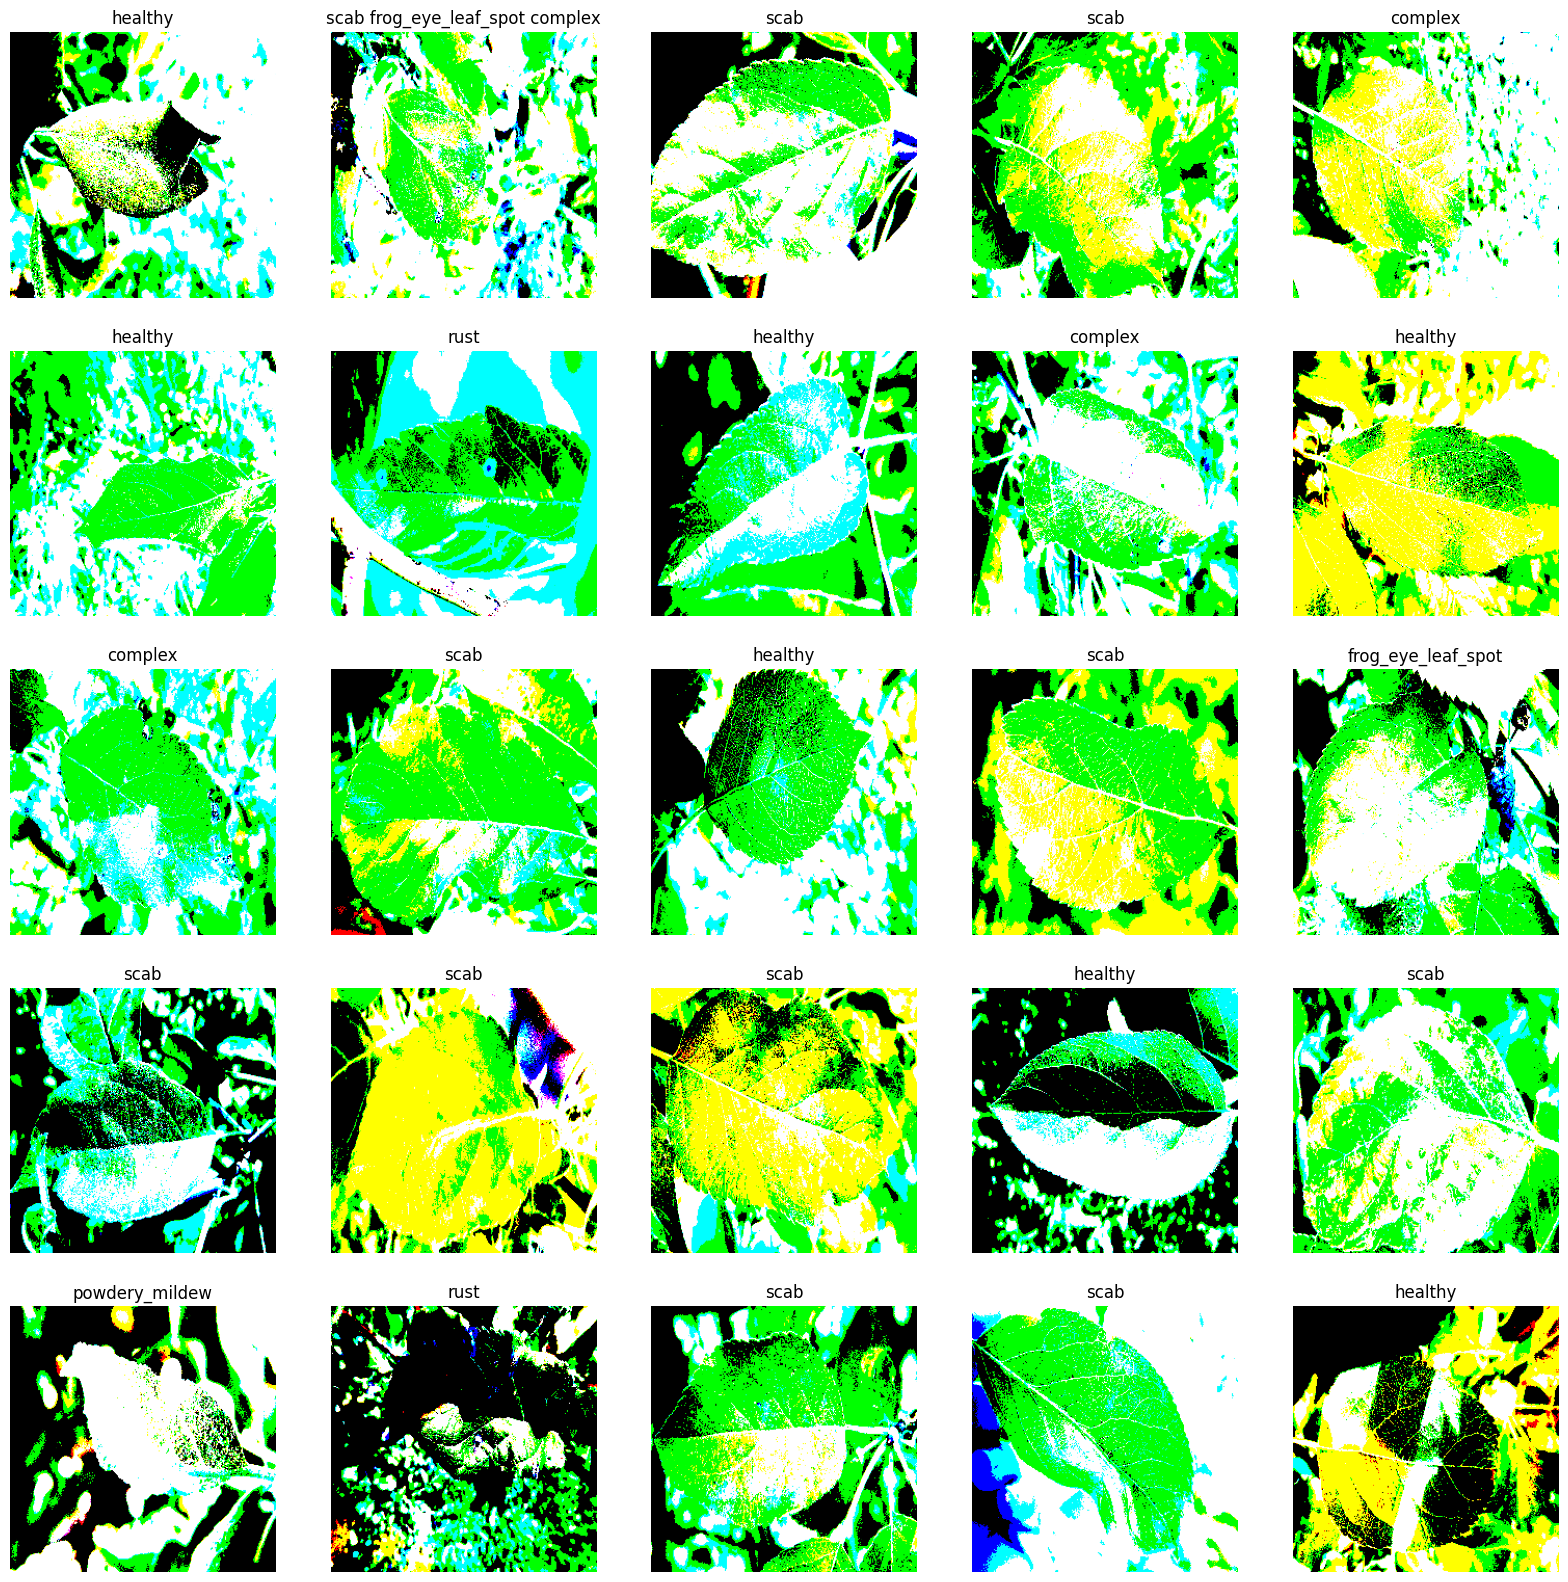

In [9]:
# Data loader sanity check
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(20,20))
    for n in range(25):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n])
        plt.title(id_to_label[label_batch[n]])
        plt.axis('off')

image_batch, label_batch = data_iterator.next() #next(iter(data))
show_batch(image_batch, label_batch)

# 2.0. Preprocessing Data

## 2.1. Scale Data

In [10]:
data = data.map(lambda x, y: (x/255, y) )

## 2.2. Split Data

In [11]:
train_size = int(len(data)*0.7)
val_size = int(len(data)*0.2)
test_size = int(len(data)*0.1)

train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

# 3.0. Deep Learning Model

## 3.1. Build CNN

In [12]:
model = Sequential()

model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dense(12, activation='softmax')) 

In [13]:
model.compile('adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 16)       0

## 3.2 Train

In [17]:
logdir = 'logs'
tensorboard_callbacks = tf.keras.callbacks.TensorBoard(log_dir=logdir)
hist = model.fit(train, epochs=5, validation_data=val, callbacks=[tensorboard_callbacks])

Epoch 1/5
408/408 [==============================] - 496s 1s/step - loss: 1.5606 - accuracy: 0.4385 - val_loss: 1.4669 - val_accuracy: 0.4941
Epoch 2/5
408/408 [==============================] - 486s 1s/step - loss: 1.1860 - accuracy: 0.5944 - val_loss: 1.2848 - val_accuracy: 0.5752
Epoch 3/5
408/408 [==============================] - 649s 2s/step - loss: 0.8681 - accuracy: 0.6949 - val_loss: 1.2740 - val_accuracy: 0.5989
Epoch 4/5
408/408 [==============================] - 552s 1s/step - loss: 0.5865 - accuracy: 0.7867 - val_loss: 1.4900 - val_accuracy: 0.5838
Epoch 5/5
408/408 [==============================] - 436s 1s/step - loss: 0.3731 - accuracy: 0.8651 - val_loss: 1.7204 - val_accuracy: 0.5749


## 3.3 Plot Performance

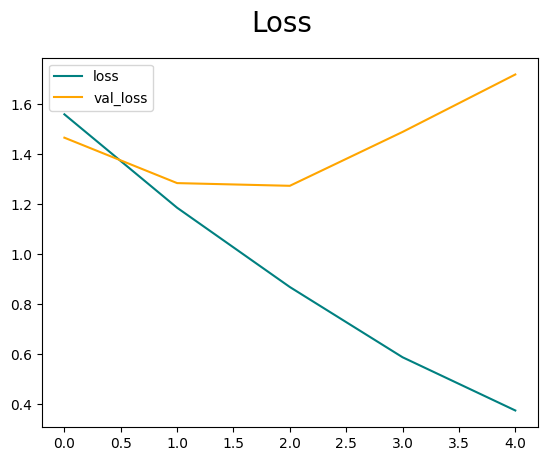

In [18]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

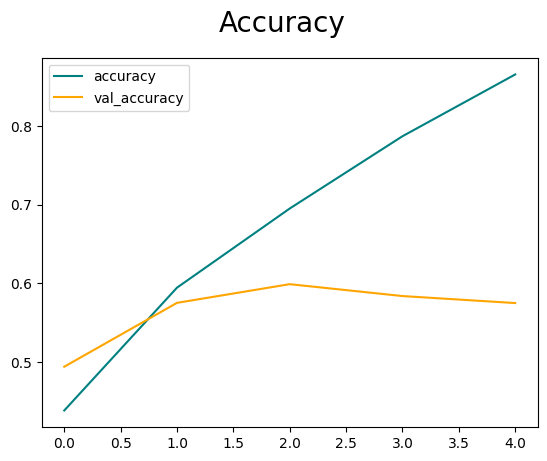

In [19]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# 4.0. Evaluate Performance

## 4.1. Evaluation Metrics

In [22]:
precision = Precision()
recall = Recall()

In [23]:
for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    precision.update_state(y, yhat)
    recall.update_state(y, yhat)

In [24]:
print(precision.result(), recall.result())

tf.Tensor(0.0, shape=(), dtype=float32) tf.Tensor(0.0, shape=(), dtype=float32)


## 4.2. Test

# 5.0. Save the Model

In [21]:
model.save(os.path.join('models','plant_disease_classifier.h5'))